<a href="https://colab.research.google.com/github/nicolinhainc/mypipeline/blob/master/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content'

/content


In [ ]:
!wget --no-check-certificate 'https://www.dropbox.com/s/nw79ua6y1nng9s4/png.zip?dl=1' -O ./png.zip


--2020-04-22 19:50:54--  https://www.dropbox.com/s/nw79ua6y1nng9s4/png.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/nw79ua6y1nng9s4/png.zip [following]
--2020-04-22 19:50:54--  https://www.dropbox.com/s/dl/nw79ua6y1nng9s4/png.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc11dd06929a81aa83dab42c22c.dl.dropboxusercontent.com/cd/0/get/A2UlUA7wK2MmyZ1c5LANVmqX8ceIdGFSimFYVAAx1fdnktVCGdCLSLzRoEFVZPnXZ8vmbXNab5hY6wiKi6e8Dr_7sbIgH-insy4KkkHHcsL8mdklaglusA5aC_tkLl-1ub0/file?dl=1# [following]
--2020-04-22 19:50:54--  https://ucc11dd06929a81aa83dab42c22c.dl.dropboxusercontent.com/cd/0/get/A2UlUA7wK2MmyZ1c5LANVmqX8ceIdGFSimFYVAAx1fdnktVCGdCLSLzRoEFVZPnXZ8vmbXNab5hY6wiKi6e8Dr_7sbIgH-insy4KkkHHcsL8mdklaglusA5aC_tkLl-

In [2]:
!unzip -q ./IDH.zip


In [1]:
# Cell #7
# now we are ready to load data and train classifier
# while we did this in separate cells before, we will do it all in one
# this should look familiar.
import numpy as np
import tensorflow as tf
!pip install tensornets
import tensornets as nets
import tensorflow_hub as hub
import keras
import tensorflow.keras 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile, preprocess_input
from tensorflow.keras.applications import VGG16
directory = "./content"

base_model=tensorflow.keras.applications.VGG16(input_shape=(181, 217, 3), include_top=False, weights='imagenet', input_tensor=None, pooling=None) #imports the nasnet large model and discards the last 1000 neuron layer.

# diesen Teil würde ich gleich hier machen, weil die Layer unten willst du ja auch jeden fall trainable haben.
# Es geht whrs darum, die Layer von deinem TransferLearning Model trainable zu machen oder?
# Dann einfach aus model --> base_model machen:

for i,layer in enumerate(base_model.layers):
  print(i,layer.name)

#for layer in base_model.layers:
#    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
#for layer in base_model.layers[:200]:
#    layer.trainable=False
#for layer in base_model.layers[201:]:
#    layer.trainable=True






x=base_model.output
#x=Flatten()(x) #either flatten with dense OR globavgpool with last layer direct (lin 2013 paper)
x=GlobalAveragePooling2D()(x)
#x=Dropout(0.7)(x)
#x=Dense()(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

#x=Dropout(0.5)(x)
x=Dense(500,activation='relu')(x) #dense layer 2
x=Dense(500,activation='relu')(x) #dense layer 2
x=Dense(500,activation='relu')(x) #dense layer 2
#x=Dense(1000,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation, for 2 classes

# Also ich verwende als ClassificationLayer immer sigmoid bei binary Classification.
# Der Wert der dann raus kommt, ist einfach die Wahrscheinlichkeit: 
# Ergebnis 0.0 --> ganz sicher Klasse 0
# Ergebnis 1.0 --> ganz sicher Klasse 1
# Ergebnis 0.5 --> ganz unsicher welche Klasse.

#preds=Dense(1,activation='sigmoid')(x)

model=Model(inputs=base_model.input,outputs=preds) 
# to load saved model with weights use 
#model= tensorflow.keras.models.load_model('./3epochtester')
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

model.trainable = True    
set_trainable = False
for layer in model.layers:
  if layer.name == 'block5_pool':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print("layer {} is {}".format(layer.name, '+++trainable' if layer.trainable else '---frozen'))




train_datagen=ImageDataGenerator(rotation_range=10, zoom_range=0.2, width_shift_range=0.1, height_shift_range=0.1, shear_range=0, brightness_range=[0.01,100], fill_mode='nearest', horizontal_flip=True, data_format='channels_last', validation_split=0.0, dtype='float32') #included in our dependencies
# add the directory below very important ##########################

train=train_datagen.flow_from_directory('./IDH/train',
                                                 target_size=(331,331),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator()

val=val_datagen.flow_from_directory('./IDH/validate',
                                                 target_size=(331,331),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=False)

# auch hier, wenn du nur 2 Klassen hast, dann nimmt man eig binary_crossentropy
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])


# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train.n//train.batch_size
step_size_val=val.n//val.batch_size
#model.fit_generator(generator=train_generator,
#                   steps_per_epoch=step_size_train,
#                   epochs=3)

history = model.fit(train, steps_per_epoch=step_size_train, epochs=30,
                              validation_data=val, validation_steps=step_size_val, 
                              verbose=1)       


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
layer input_1 is ---frozen
layer block1_conv1 is ---frozen
layer block1_conv2 is ---frozen
layer block1_pool is ---frozen
layer block2_conv1 is ---frozen
layer block2_conv2 is ---frozen
layer block2_pool is ---frozen
layer block3_conv1 is ---frozen
layer block3_conv2 is ---frozen
layer block3_conv3 is ---frozen
layer block3_pool is ---frozen
layer block4_conv1 is ---frozen
layer block4_conv2 is ---frozen
layer block4_conv3 is ---frozen
layer block4_pool is ---frozen
layer block5_conv1 is ---frozen
layer block5_conv2 is ---frozen
layer block5_conv3 is ---frozen
layer block5_pool is +++trainable
layer global_average_pooling2d is +++trainable
layer dense is +++trainable
layer dense_1 is +++trainable
layer dens

KeyboardInterrupt: ignored

In [ ]:
model.save('./3epochtester',save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./3epochtester/assets


In [ ]:
# next cell to save model including newly trained weights
# model.save('myLGGtestmodel.h5') # rename it how you like, it will show up in your directory. I have explained above using a hastag how and where to load the model.

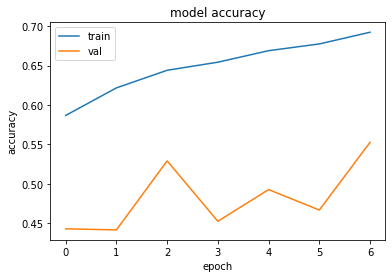

In [ ]:
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ValueError: ignored

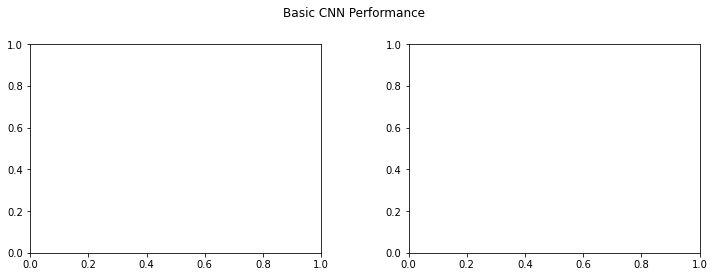

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,4))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 4, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 4, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# this cell is to evaluate loss and accuracy on an external test set

model.evaluate(val, verbose=1, sample_weight=None, steps=step_size_val, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:
# this cell is to predict image classes

predictions=model.predict(val, verbose=1, steps=step_size_val, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

 

22/22 [==============================] - 12s 535ms/step


In [ ]:
print([sum(x)/len(x) for x in zip(*predictions)])
#this gets you the averages for each position in the array!!!


[0.5863971998491748, 0.41360280180180614]
